## Домашнее задание 2

Стребежев Игорь

In [2]:
%%html
<style>video{width:480px;height:480px}</style>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib as mpl
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(threshold=np.inf)
plt.rc('animation', html='html5')
plt.rcParams["figure.figsize"] = 8, 8

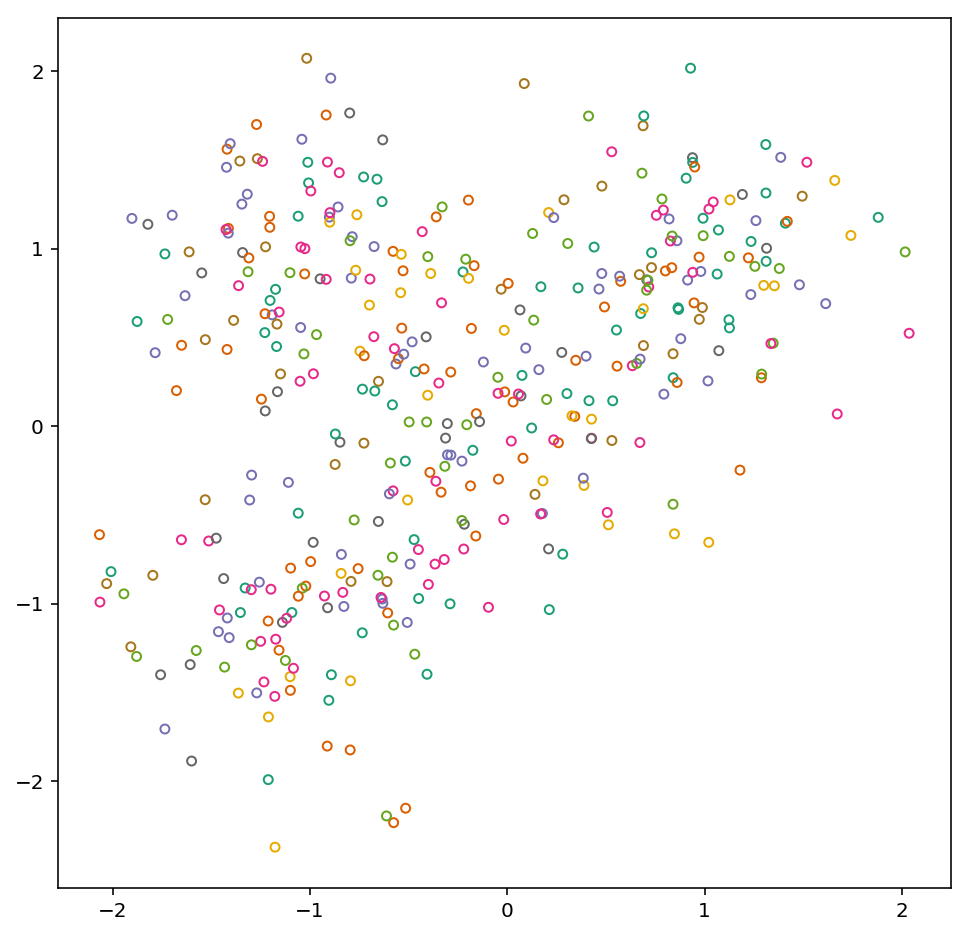

In [3]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean

df = pd.read_csv('blobs.csv')
data = df.as_matrix()

colors = plt.cm.Dark2(np.linspace(0, 1, 256))
X, Y = df.X.values, df.Y.values
plt.scatter(X, Y, 20, color='none', edgecolors=colors)

### task 1

Реализуйте алгоритм $\texttt{k-means}$ для кластеризации на 2-4 кластера.

In [32]:
fig = plt.figure(dpi=120); plt.close(); ax = fig.add_subplot(111); pictures  = []


def kmeans(k=4, eps=0.0005, animation=False):
    pictures  = []
    centroids = np.random.uniform(np.amin(data, 0), high=np.amax(data, 0), size=(k, data.shape[1]))
    changes   = True

    while changes:
        clasters  = np.argmin(cdist(data, centroids)**2, axis=1)
        means     = np.array([data[clasters == i].mean(axis=0) for i in range(k)])
        changes   = (np.hstack(abs(centroids - means)) > eps).all()
        centroids = means

        if animation:
            pictures.append([
                ax.scatter(data[:,0], data[:,1], 20, color=plt.cm.Dark2(clasters)),
                ax.scatter(centroids[:,0], centroids[:,1], 100, color='red')
            ])
            
    if animation:
        return mpl.animation.ArtistAnimation(fig, pictures, interval=500)
    return centroids, clasters

In [35]:
kmeans(k=2, animation=True)

In [37]:
kmeans(k=3, animation=True)

In [38]:
kmeans(k=4, animation=True)

In [39]:
kmeans(k=10, animation=True)

### task 2

Реализуйте алгоритм $\texttt{DBSCAN}$, найдите параметры для кластеризации на 4 кластера. 

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


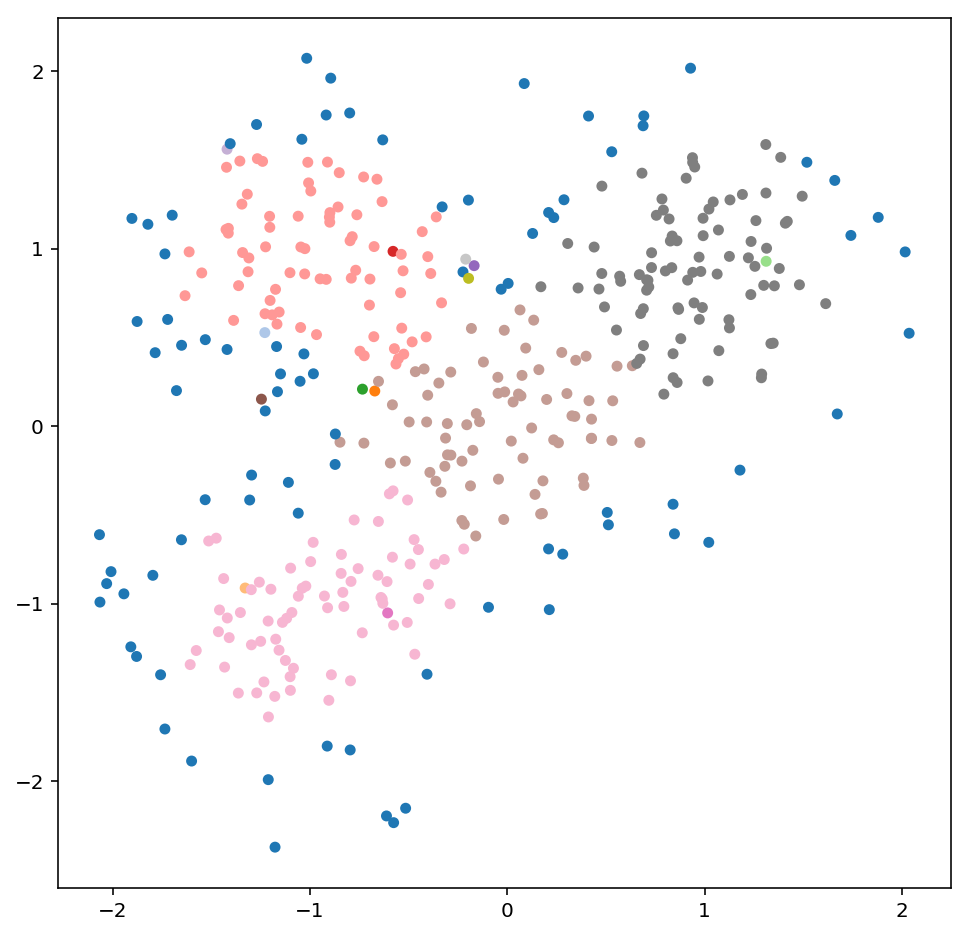

In [252]:
def DBSCAN(eps, minPts):
    reachable   = cdist(data, data)  <  eps
    core_sample = reachable.sum(axis=1) >= minPts
    clasters    = [-1 for i in range(X.size)]
    
    def dfs(v, c):
        clasters[v] = c
        if not core_sample[v]: return
        for i in range(X.size):
            if reachable[v, i] and clasters[i] == -1:
                dfs(i, c)
            
    c = 0
    for i in range(X.size):
        if clasters[i] == -1 and is_core_sample[i]:
            dfs(i, c)
            c += 1
            
    print(np.unique(clasters))
    return plt.scatter(data[:,0], data[:,1], 20, color=plt.cm.tab20(clasters))
        
    
DBSCAN(0.38, 26)

### task 3

Реализуйте алгоритм $\texttt{Аffinity Propagation}$, найдите параметры для кластеризации на $<4$,
$4$, $>4$ кластеров.

$$r(i,k) \leftarrow s(i,k) - \max_{k' \neq k} \left\{ a(i,k') + s(i,k') \right\}$$

$$a(i,k) \leftarrow \min \left( 0, r(k,k) + \sum_{i' \not\in \{i,k\}} \max(0, r(i',k)) \right) \text{for } 
i \neq k$$

$$ a(k,k) \leftarrow \sum_{i' \neq k} \max(0, r(i',k))$$

In [9]:
def ap(diagonal_value):
    iterations = 500
    noice      = 0.5
    
    s = -cdist(data, data)**2 * 1.0
    np.fill_diagonal(s, diagonal_value)
    
    n = s.shape[0]
    a = np.zeros((n, n))
    r = np.zeros((n, n))

    # add noise to improve float operations
    floats = np.finfo(np.float)
    seed   = np.random.RandomState(0)
    s     += ((floats.eps * s + floats.tiny * 100) * seed.randn(n, n))


    for it in range(iterations):
        # n order statistics of each row
        expr = a + s
        maxi = np.arange(n), expr.argmax(axis=1)
        maxv = expr[maxi]
        
        # n-1 order statistics of each row
        expr[maxi] = -np.inf
        maxv2 = np.max(expr, axis=1)

        # compute r
        np.exprtract(s, maxv[:, np.newaxis], expr)
        expr[maxi] = s[maxi] - maxv2

        # noice
        r = (r * noice) + expr * (1 - noice)

        # max in a formula
        np.maximum(r, 0, expr)
        expr[np.diag_indices(n)] = np.diagonal(r)

        # compute a
        expr -= np.sum(expr, axis=0)
        da = np.diag(expr).copy()
        expr.clip(0, np.inf, expr)
        expr[np.diag_indices(n)] = da

        # noice
        expr *= 1 - noice
        a *= noice
        a -= expr


    # get examplars & classes
    ex = np.where(np.diag(a + r) > 0)[0]
    cl = np.argmax(s[:, ex], axis=1)
    cl[ex] = np.arange(ex.size)

    # reify examplars indexes
    for i in range(ex.size):
        idxes   = np.where(cl == i)[0]
        rowsums = np.sum(s[idxes[:, np.newaxis], idxes], 0)
        ex[i]   = idxes[np.argmax(rowsums)]

    cl = np.argmax(s[:, ex], axis=1)
    cl[ex] = np.arange(ex.size)
    labels = ex[cl]
    
    # draw
    examplars = np.unique(labels)
    plt.scatter(data[:,0], data[:,1], 20, color=plt.cm.Dark2(cl)),
    plt.scatter(data[examplars][:,0], data[examplars][:,1], 100, color='red')
    return cl

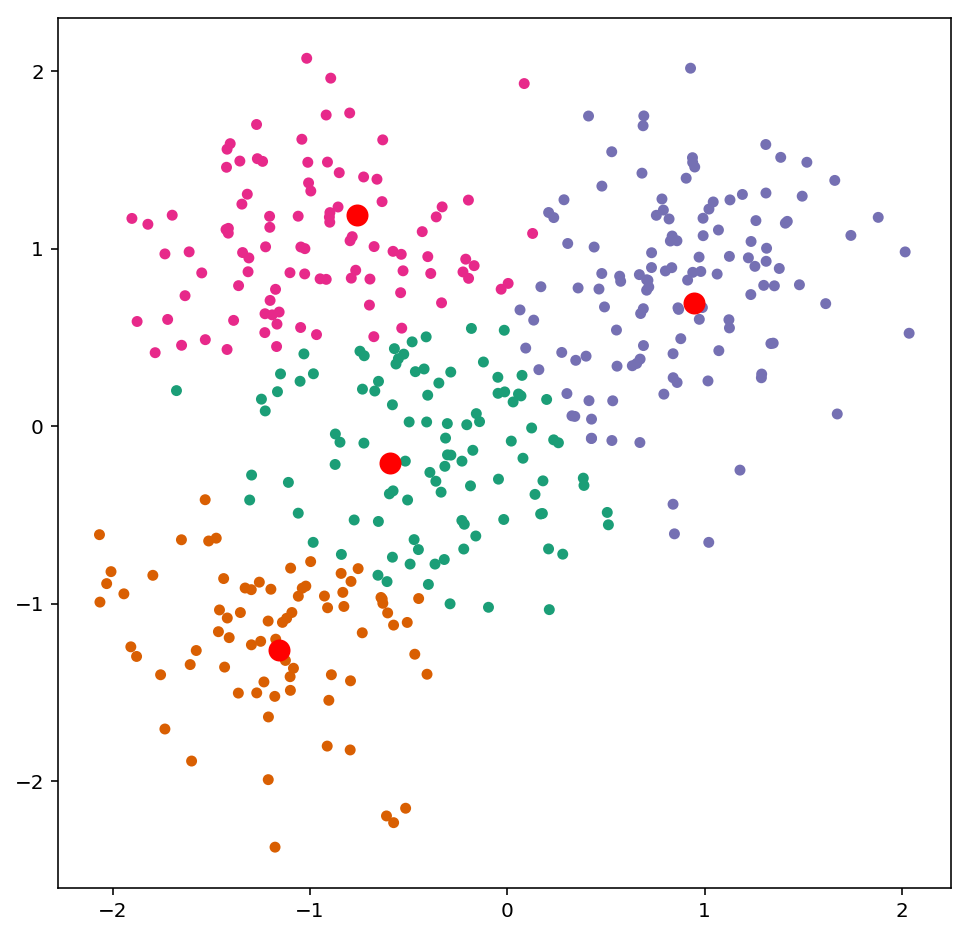

In [226]:
# 4 clasters
ap(-79)

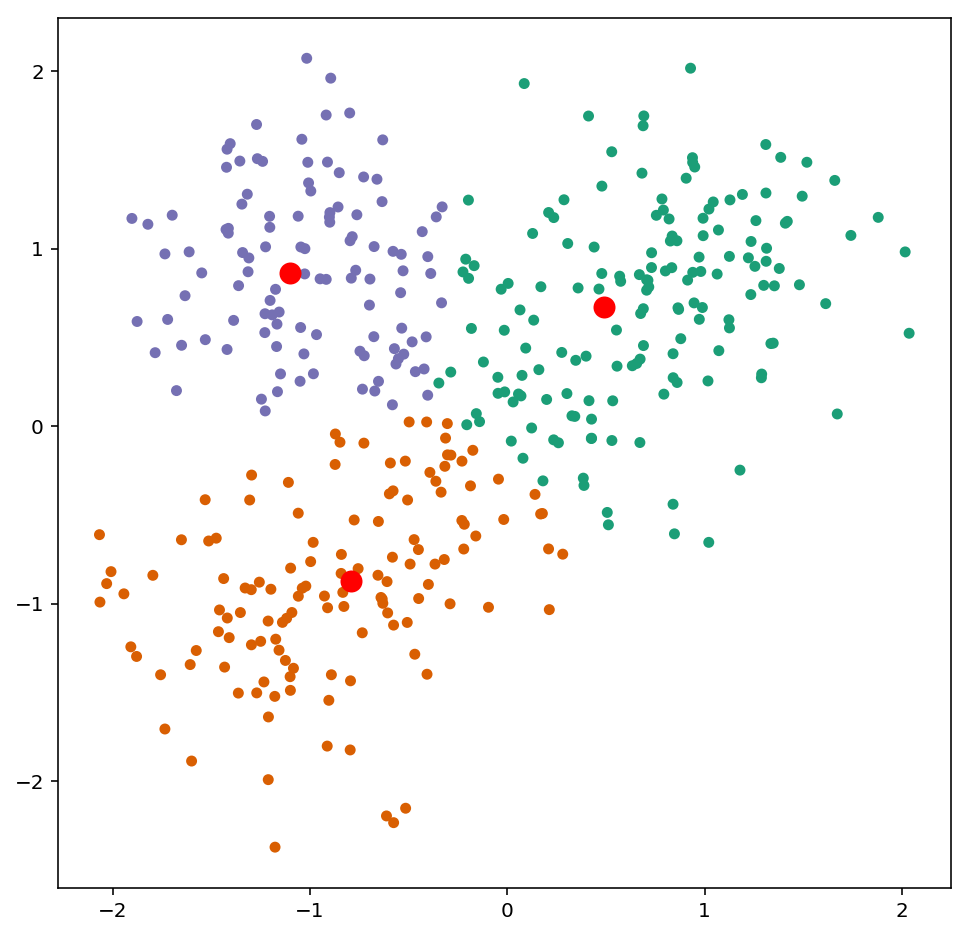

In [222]:
# 3 clasters
ap(-76)

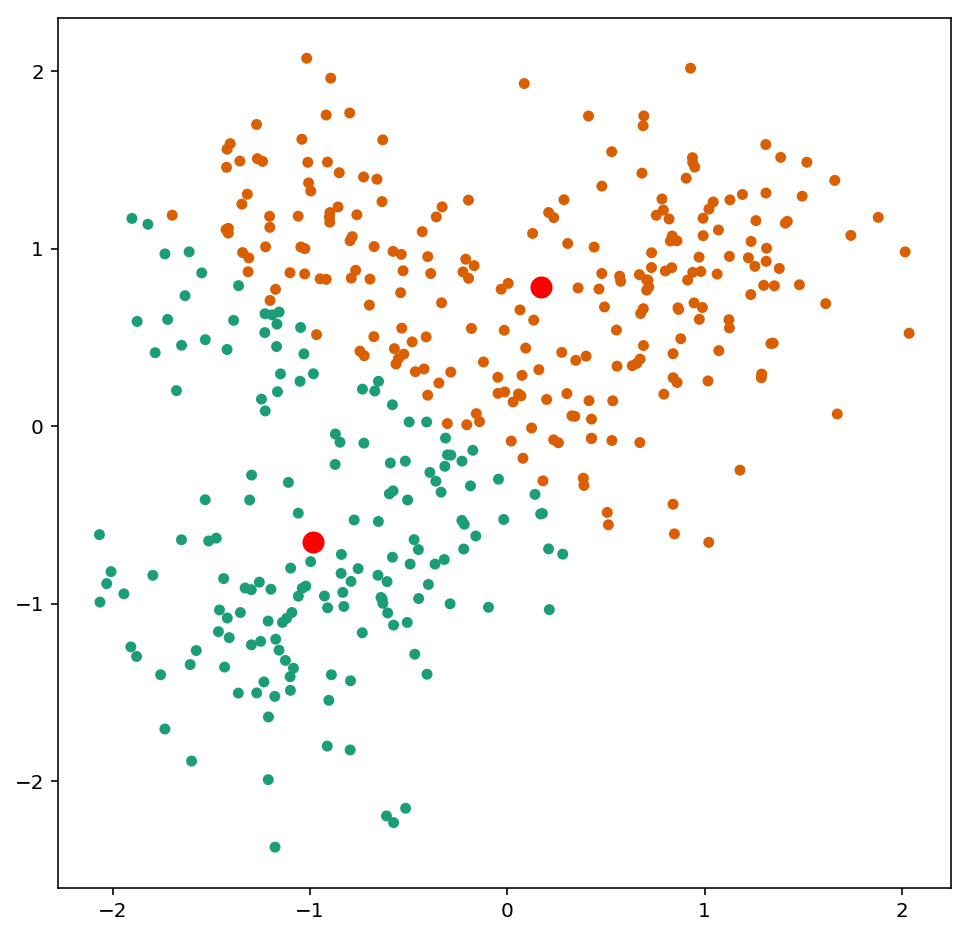

In [223]:
# 2 clasters
ap(-83.5)

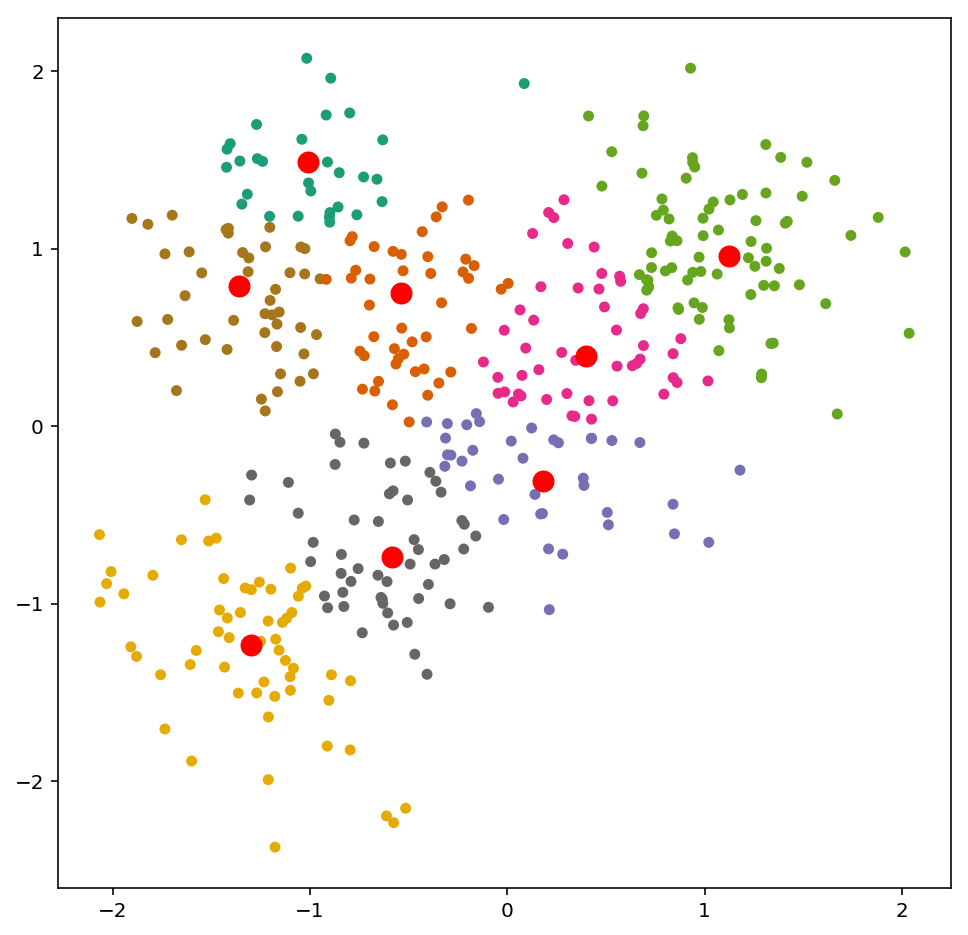

In [225]:
# 8 clasters
ap(-10)

### task 4

Реализуйте кластеризацию данных из датасета `spambase.csv` (с нормировкой и без) на
2-6 кластеров методом $\texttt{k-means}$ и посчитайте метрику purity по каждому варианту.

In [166]:
import warnings


dfs = pd.read_csv('../hw01_knn/spambase.csv')
dfs.head()

Y    = dfs.label.values
data = dfs[dfs.columns.drop('label')].as_matrix()

def purity():
    for k in range(1, 8):
        # try to find the right random points
        for it in range(2000):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                _, cl = kmeans(k)
                if np.unique(cl).size == k: break

        # sum sizes of the most popular group in each cluster
        purity = sum(np.bincount(Y[(cl == i).nonzero()[0]]).max() for i in range(k)) / Y.size
        print(f'k={k}, purity=' + str(purity))

In [167]:
purity()

k=1, purity=0.6059552271245382
k=2, purity=0.6066072592914584
k=3, purity=0.6070419474027385
k=4, purity=0.6068246033470984
k=5, purity=0.6124755487937404
k=6, purity=0.6153010215170616
k=7, purity=0.6179091501847425


In [168]:
data = (data - data.min(0)) / data.ptp(0)
purity()

k=1, purity=0.6059552271245382
k=2, purity=0.6059552271245382
k=3, purity=0.6059552271245382
k=4, purity=0.6059552271245382
k=5, purity=0.6059552271245382
k=6, purity=0.6059552271245382
k=7, purity=0.6072592914583786
